Your car's odometer works by counting the rotations of the wheels and multiplying by the circumference of the wheel/tyre.
However, computer vision makes it possible to get similar measurements by just *looking* at the motion of the car.
This is Visual Odometry (VO) -- odometry using vision.

In this post I am going to try and perform monocular VO (VO with one camera) on a stock dashcam video that I downloaded off the internet.
If VO is any good as far as applications are concerned, it should work on any video.
My goal for this post is to learn how to use the OpenCV python library and computer vision concepts in the process.
The code and video for this can be found on [my GitHub](https://github.com/vibhavgaur/VisualOdometry).

A note before we go ahead -- I am still learning this stuff so I may promise something at the start of the post and not deliver on it (in the same post) because I got stuck or had to do something else.
But the point of this is to learn by feeling our way through this stuff, there are plenty of concrete resources if you want to get it right in the first try.
I feel this way is more conducive to learning.

### Main Idea

The central idea in VO is that one can detect features in each frame, match those features across a number of frames, and therefore estimate the motion of the camera.
In this post, I will attempt the first portion of this problem which is to estimate camera motion between two successive frames.
Once I have that running, I will extend that to the whole video in a subsequent post.
Let's get into it.

In [137]:
# %matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np

cap = cv2.VideoCapture("DrivingVideo.mp4")
print("Number of frames in video: ", cap.get(cv2.CAP_PROP_FRAME_COUNT))
W, H = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("Width, Height: ", W, H)

Number of frames in video:  813.0
Width, Height:  1280 720


In [138]:
frame1 = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(cap.read()[1], cv2.COLOR_BGR2RGB)

There will be a lot of comparing two frames side by side, so I'm going to write a handy function to take care of that.

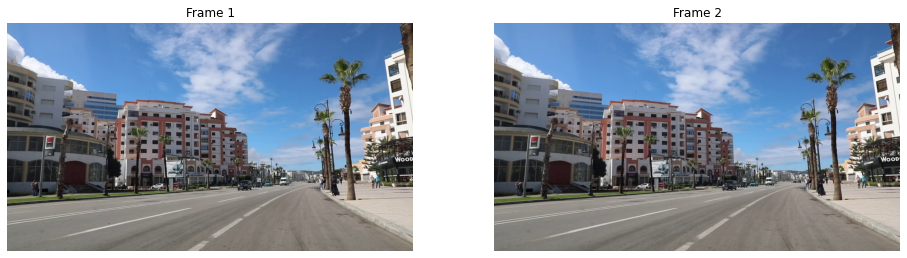

In [139]:
def showImages(frame1, frame2):
    f, ax = plt.subplots(1,2,figsize=[16,16])
    ax[0].imshow(frame1), ax[1].imshow(frame2)
    ax[0].axis('off'), ax[1].axis('off'), ax[0].title.set_text('Frame 1'), ax[1].title.set_text('Frame 2')

showImages(frame1, frame2)

### Feature detection

I will be detecting ORB features in the images. 
I don't have a good idea of what exactly these features look for, but I do know that they are free to use (unlike SIFT features) and perform quite well.
The key is to write code that is indifferent to the feature detector used.
OpenCV's design lends itself well to this style, since all I have to change is the first line below if I wished to use a different detector.

A **feature descriptor** is a vector of numbers that tries to uniquely identify a feature.
One can think of it like a fingerprint for the feature.
When we find matches for features in different frames, we will do so using the descriptors.

Number of keypoints:  500  and  500
Descriptors:  (500, 32) (500, 32)


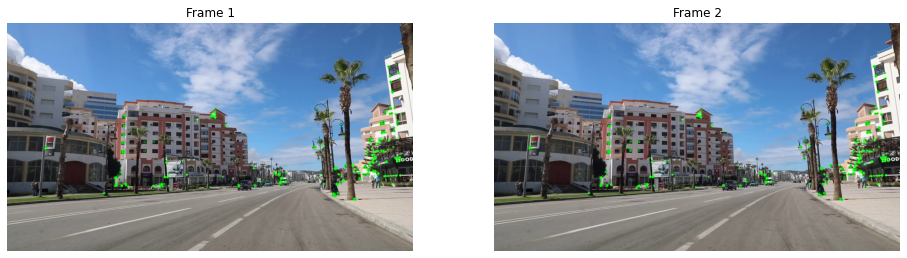

In [140]:
detector = cv2.ORB_create()
kp1, kp2 = detector.detect(frame1, None), detector.detect(frame2, None)
print("Number of keypoints: ", len(kp1)," and ", len(kp2))
kp1, des1 = detector.compute(frame1, kp1)
kp2, des2 = detector.compute(frame2, kp2)
print("Descriptors: ", des1.shape, des2.shape)

frame1_kp = cv2.drawKeypoints(frame1, kp1, None, color=(0,255,0), flags=0)
frame2_kp = cv2.drawKeypoints(frame2, kp2, None, color=(0,255,0), flags=0)
showImages(frame1_kp, frame2_kp)

Using the default settings for the ORB detector, 500 features are detected. 
These points are called the **keypoints** and they are drawn on their respective frames as green dots.
The detected features should ideally be distributed well all over the image for a good estimation of camera motion ultimately.
This is not the case here -- we will have to do something about that.
Also note that the descriptors are a 500 $\times$ 32 matrix, i.e. for each keypoint, there is a 32-dimensional vector that is its descriptor.
I believe the 32 is a function of the definition of the detector.

### Feature matching

There are many algorithms to match features, but I went with the simple (yet effective) brute-force matcher.
The metric being used to match features is the Hamming Norm.
I think its just matches features by looking at which descriptors end up closest in that 32-dimensional descriptor space, i.e. its just looking at the [Hamming distance](https://en.wikipedia.org/wiki/Hamming_distance) between those 32-dimensional vectors.

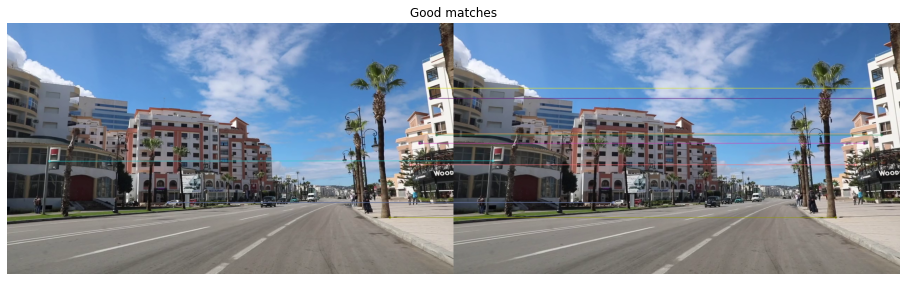

In [141]:
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = matcher.match(des1, des2)

matches = sorted(matches, key = lambda x:x.distance)
framesMatched = cv2.drawMatches(frame1, kp1, frame2, kp2, matches[:10], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = [16,16]), plt.axis('off'), plt.title("Good matches"), plt.imshow(framesMatched), plt.show();

The image above (poorly) shows the top 10 matches between the two frames.
As can be seen, they correspond to the same objects in physical space (such as the corner of the window in the top right).
This is a good thing.
However, not all matches are good quality like that.
If I look at the 10 worst matches, this is what we get.

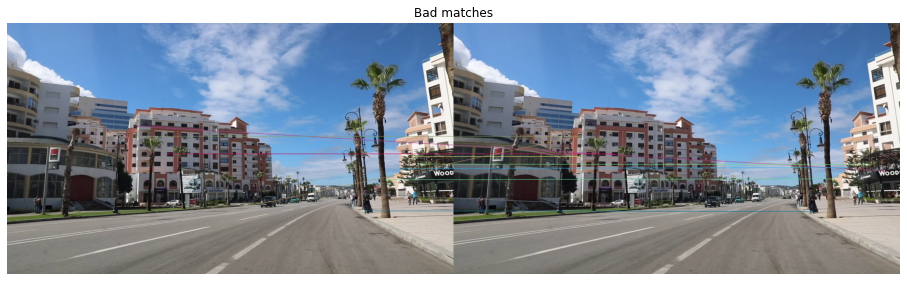

In [142]:
framesBadMatches = cv2.drawMatches(frame1, kp1, frame2, kp2, matches[-10:], None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = [16,16]), plt.axis('off'), plt.title("Bad matches"), plt.imshow(framesBadMatches), plt.show();

Notice how these "matches" don't actually point to the same physical object -- making these bad matches.
We want to get rid of bad matches so it doesn't throw off our eventual motion estimation.
Here is where some knowledge about camera models and projective geometry will come in.

Let's check how good our matches really are. We can look at the distance of each match -- the lower the better.

In [143]:
print("Number of matches: ", len(matches))
print([m.distance for m in matches])

Number of matches:  383
[2.0, 2.0, 2.0, 3.0, 3.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 

Hmm, that doesn't look too promising.
We have 383 matches from our 500 keypoints, but a lot of them are kinda far in terms of the Hamming distance. 
This means that a lot of them are bad features.
We will have to use a different method to find our matches.
I'll look into that in my next post.

### References

* [First Principles of Computer Vision](https://www.youtube.com/channel/UCf0WB91t8Ky6AuYcQV0CcLw) YouTube channel
* [twitchslam](https://github.com/geohot/twitchslam) by George Hotz
* [KITTI Odometry with OpenCV Python](https://www.youtube.com/playlist?list=PLrHDCRerOaI9HfgZDbiEncG5dx7S3Nz6X) by Nate Cibik
* Visual Odometry by David Scaramuzza and Friedrich Fraundorfer